Processing PictureNaming folder...
Found 1652 npy files
0 files with all 0 values
Processing EarlyLate folder...
Found 3971 npy files
nan in /data/storage500/Turntaking/wavs_single_channel_normalized_nosil/EarlyLate-features/jitter/subj-2120_27_E_kwaad_geloof.wav_1.wav_jitter.npy
0 files with all 0 values
Processing BoundaryTone folder...
Found 5026 npy files
0 files with all 0 values
warning 'age' has 156 NaN, has been deleted
Experiment Levels: Index(['exp_2_EarlyLate', 'exp_1_PictureNaming', 'exp_3_BoundaryTone'], dtype='object')
            experiment group_id                   value subject_id  \
0  exp_1_PictureNaming       HC  [0.021579830749940257]       2126   
1  exp_1_PictureNaming       HC  [0.030827921605807555]       2104   
2  exp_1_PictureNaming       HC  [0.015053068922943754]       2129   
3  exp_1_PictureNaming       PD  [0.026192795152750557]       2214   
4  exp_1_PictureNaming       HC   [0.02136526112037015]       2118   

                 filename          item 

/data/storage500/yzhongenvgpu/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/tmp/ipykernel_3619/1466578901.py:160: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


Linear mixed model fit by REML [’lmerMod’]
Formula: value~age+group_id*experiment+group_id*gender+(1|subject_id)+(1|item)

Family: gaussian	 Inference: parametric

Number of observations: 7762	 Groups: {'item': 140.0, 'subject_id': 51.0}

Log-likelihood: 26460.619 	 AIC: -52897.237

Random effects:

                   Name  Var    Std
item        (Intercept)  0.0  0.004
subject_id  (Intercept)  0.0  0.004
Residual                 0.0  0.008

No random effect correlations specified

Fixed effects:

                                          Estimate     SE  T-stat  P-val Sig
(Intercept)                                  0.021  0.008   2.751  0.008  **
age                                          0.000  0.000   0.936  0.354    
group_idPD                                  -0.004  0.002  -2.074  0.044   *
experimentexp_1_PictureNaming               -0.002  0.001  -2.972  0.003  **
experimentexp_3_BoundaryTone                 0.000  0.003   0.055  0.956    
genderM                            

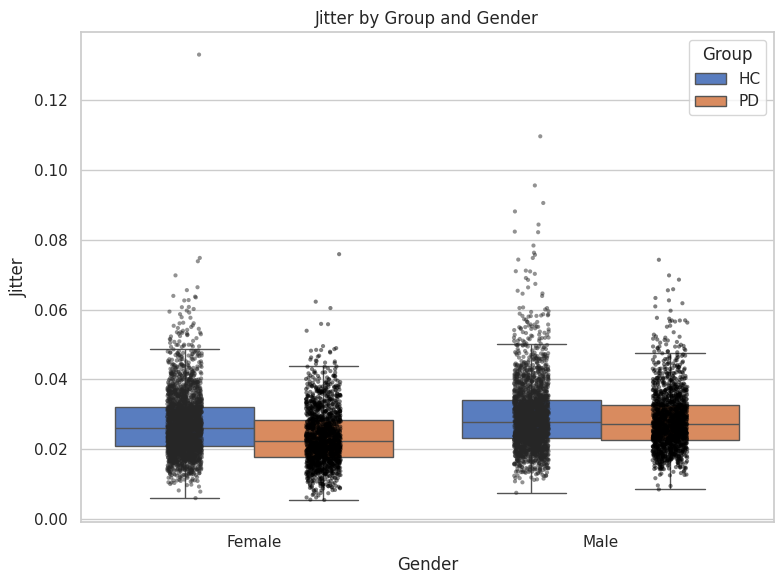

Jitter visualization saved to './res_lme/jitter_visualization_EL.png'


In [37]:
import pandas as pd
from pymer4.models import Lmer

from load_feat_pd import *
import matplotlib.pyplot as plt
import seaborn as sns


def lme(metadata, outfile, featname='shimmer', level='utt', stats='mean'):

    df = pd.DataFrame(metadata)
    
    # remove group id == '11':
    df = df[df['group_id'] != '11']
    
    # map group_id 21 to HC 22 to PD
    df['group_id'] = df['group_id'].map({'21': 'HC', '22': 'PD'})


    # change age from string to int
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    missing_age = df['age'].isnull().sum()
    if missing_age > 0:
        print(f"warning 'age' has {missing_age} NaN, has been deleted")
        df = df.dropna(subset=['age'])
        
    # add one more column item name in the filename
    df['item'] = df['filename'].apply(lambda x: x.split('.')[0].split('_')[-1])
    
    # df['group_id'] = pd.Categorical(df['group_id'], categories=['PD', 'Control'])
    df['gender'] = pd.Categorical(df['gender'], categories=['V', 'M'])
    df['experiment'] = pd.Categorical(df['experiment'], categories=['exp_1_PictureNaming', 'exp_2_EarlyLate', 'exp_3_BoundaryTone'])

    # print("Group ID Levels:", df['group_id'].cat.categories)       # 输出: ['PD', 'Control']
    # print("Gender Levels:", df['gender'].cat.categories)           # 输出: ['Female', 'Male']
    print("Experiment Levels:", df['experiment'].cat.categories)   # 输出: ['Baseline', 'EarlyLate', 'BoundaryTone']

    print(df.head())


    if level == 'utt':
        # change the value from np array to float value
        df['value'] = df['value'].apply(lambda x: x[0])
        
    elif level == 'frame':
        if stats == 'mean':
            df['value'] = df['value'].apply(lambda x: x.mean())
        elif stats == 'std':
            df['value'] = df['value'].apply(lambda x: x.std())
        elif stats == 'median':
            df['value'] = df['value'].apply(lambda x: np.median(x))

    # print(df.head())
    # print(df.shape)
    featname = "response_time" if featname == 'rp' else featname
    valuetype = stats if level == 'frame' else ''

    print(f'=============== value: {featname}_{valuetype} ====================\n')


    model = Lmer("value ~ age + group_id*experiment + group_id*gender + (1|subject_id) + (1|item)", data=df)
                        

    result = model.fit()

    
        
    with open(outfile, 'a') as f:
        f.write(f'\n')
        f.write(f'=============== value: {featname}_{valuetype} ====================\n')
        f.write(result[['Estimate', 'SE', 'T-stat', 'P-val', 'Sig']].to_string())    
        f.write(f'\n')
        f.write(model.ranef_var.to_string())
        f.write(f'\n')
    
    print(result[['Estimate', 'SE', 'T-stat', 'P-val', 'Sig']])

    return df



def visualize_feat(df, featname, outfile):
    """
    Visualizes the specified feature with respect to group (PD vs HC) and gender (Female vs Male).
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - featname: str, name of the feature to visualize.
    - outfile: str, path to save the visualization.
    - significance: bool, whether to add significance annotations.
    """
    # Map gender codes to labels
    df['gender'] = df['gender'].map({'V': 'Female', 'M': 'Male'})
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(8, 6))
    
    # Bar Plot with error bars (standard deviation)
    ax = sns.barplot(x='gender', y='value', hue='group_id', data=df, ci='sd', palette='muted')
    
    plt.title(f'{featname.capitalize()} by Group and Gender')
    plt.xlabel('Gender')
    plt.ylabel(featname.capitalize())
    
    # Add individual data points
    sns.stripplot(x='gender', y='value', hue='group_id', data=df, 
                  dodge=True, color='black', alpha=0.5, size=3)
    
    # Adjust the legend to avoid duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend(handles[:2], labels[:2], title='Group')
    
    
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()
    
    print(f"{featname.capitalize()} visualization saved to '{outfile}'")


def visualize_feat_boxplot(df, featname, outfile):
    """
    Visualizes the specified feature with respect to group (PD vs HC) and gender (Female vs Male) using a box plot.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - featname: str, name of the feature to visualize (used for labeling).
    - outfile: str, path to save the visualization.
    """
    # Map gender codes to labels
    df['gender'] = df['gender'].map({'V': 'Female', 'M': 'Male'})
    
    # Verify that 'value' column exists
    if 'value' not in df.columns:
        raise ValueError("The DataFrame does not contain a 'value' column.")
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(8, 6))
    
    # Box Plot using 'value' as the y-axis
    ax = sns.boxplot(
        x='gender',
        y='value',            # Use 'value' instead of featname
        hue='group_id',
        data=df,
        palette='muted',
        showfliers=False     # Optional: hide outliers
    )
    
    plt.title(f'{featname.capitalize()} by Group and Gender')
    plt.xlabel('Gender')
    plt.ylabel(featname.capitalize())
    
    # Add individual data points
    sns.stripplot(
        x='gender',
        y='value',            # Use 'value' instead of featname
        hue='group_id',
        data=df,
        dodge=True,
        color='black',
        alpha=0.5,
        size=3
    )
    
    # Adjust the legend to avoid duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend(handles[:2], labels[:2], title='Group')
    
    plt.tight_layout()
    plt.savefig(outfile, dpi=300)
    plt.show()
    
    print(f"{featname.capitalize()} visualization saved to '{outfile}'")




        
if __name__ == '__main__':
    base_folder_path_unnorm = Path('/data/storage500/Turntaking/wavs_single_channel_nosil')
    base_folder_path = Path('/data/storage500/Turntaking/wavs_single_channel_normalized_nosil')

    feats2level = {
        'jitter': 'utt',
        'shimmer': 'utt',
        'rp': 'utt',
        'f0': 'frame',
        'energy': 'frame'
    }

    np.set_printoptions(precision=2)
    allfeats = ['jitter', 'shimmer', 'rp', 'f0', 'energy']
    # for feat in allfeats:
    allfeats = ['jitter']
    
    outfile = './res_lme/res_v1_V_PN.txt'
    # if exist, remove the file
    if os.path.exists(outfile):
        os.remove(outfile)
    
    feature_dfs = {}  # Dictionary to store DataFrames for each feature
    
    for featname in allfeats:
        folder = base_folder_path_unnorm if featname == 'energy' else base_folder_path

        if feats2level[featname] == 'frame':
            metadata = load_feat(folder, feature_name=featname)
            df = lme(metadata, outfile, featname=featname, level=feats2level[featname], stats='mean')
            feature_dfs[featname + '_mean'] = df

            df = lme(metadata, outfile, featname=featname, level=feats2level[featname], stats='std')
            # Optionally, process 'std' or other statistics
            feature_dfs[featname + '_std'] = df
            
        else:
            metadata = load_feat(folder, feature_name=featname)
            df = lme(metadata, outfile, featname=featname, level=feats2level[featname])
            feature_dfs[featname] = df
    
        
    for featname in feature_dfs.keys():
        visualize_feat_boxplot(feature_dfs[featname], featname, f'./res_lme/{featname}_visualization.png')


